In [48]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
import time
# for reproducing result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [24]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (7,4) autoencoder n_channel = 7 and M = 2^4 = 16 
M = 4
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


In [25]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)

In [26]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [27]:
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 4)


In [28]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350, 100]
for i in temp_check:
    print(label[i],data[i])

1 [0. 1. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]


# Autoencoder network definition

In [29]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*\
                  K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

In [30]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
Total para

In [31]:
# for tensor board visualization
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# Training phase

In [32]:
# train autoencoder
autoencoder.fit(data, data,
                epochs=45,
                batch_size=32,
                callbacks=[tbCallBack])

Epoch 1/45
8000/8000 [==============================] - 1s 83us/step - loss: 0.3975
Epoch 2/45
8000/8000 [==============================] - 1s 66us/step - loss: 0.0183
Epoch 3/45
8000/8000 [==============================] - 1s 63us/step - loss: 0.0120
Epoch 4/45
8000/8000 [==============================] - 0s 58us/step - loss: 0.0099
Epoch 5/45
8000/8000 [==============================] - 1s 63us/step - loss: 0.0068
Epoch 6/45
8000/8000 [==============================] - 0s 58us/step - loss: 0.0083
Epoch 7/45
8000/8000 [==============================] - 0s 60us/step - loss: 0.0058
Epoch 8/45
8000/8000 [==============================] - 0s 57us/step - loss: 0.0089
Epoch 9/45
8000/8000 [==============================] - 1s 64us/step - loss: 0.0085
Epoch 10/45
8000/8000 [==============================] - 1s 65us/step - loss: 0.0049
Epoch 11/45
8000/8000 [==============================] - 1s 63us/step - loss: 0.0052
Epoch 12/45
8000/8000 [==============================] - 0s 62us/step - lo

In [33]:
# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
autoencoder.save('autoencoder_v_best.model')

# Analyze weights

In [34]:
def print_weights(net):
    for layer in range(0, len(net.layers)):
        #tf.summary.histogram("weights_" + str(layer), net.layers[layer].get_weights()[0])
        print('shape of layer #', layer, ' is : ', len(net.layers[layer].get_weights()))
        for idx in range(0, len(net.layers[layer].get_weights())):
            print('weights layer #', layer, ' index # ', idx)
            print(net.layers[layer].get_weights()[idx])
            print('')
        print('------------------------------')

## Encoder

In [35]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)
print (encoder.summary())
print('*****************************************************************')
print_weights(encoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
*****************************************************************
shape of layer # 0  is :  0
------------------------------
shape of layer # 1  is :  2
weights layer # 1  index #  0
[[-0.86180604  1.0006561   0.03171489 -0.5137545 ]
 [-0.89217997 -0.51101834 -0.5136323  -

## Decoder

In [36]:
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)
print (decoder.summary())
print('*****************************************************************')
print_weights(decoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None
*****************************************************************
shape of layer # 0  is :  0
------------------------------
shape of layer # 1  is :  2
weights layer # 1  index #  0
[[ 2.5934687  -3.3166964   1.6610289  -0.78468263]
 [ 0.5585344   0.6446199  -2.279601   -4.1293836 ]]

weights layer # 1  index #  1
[ 1.6403215   1.3777707  -0.23649213  1.4017253 ]

------------------------------
shape 

# Inference phase

In [ ]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [46]:
# Generates N symbols. Can be either:
# [ 1 0 0 0 ] or
# [ 0 1 0 0 ] or
# [ 0 0 1 0 ] or
# [ 0 0 0 1 ]
def generate_random_data(N):
    test_label = np.random.randint(4, size=N)
    test_data = []
    for i in test_label:
        temp = np.zeros(4)
        temp[i] = 1
        test_data.append(temp)
    test_data = np.array(test_data)
    return test_data

## Constelation diagram

i = 0 : [1. 0. 0. 0.]
[[-1.0350922 -0.9636306]]
power: 0.9999999828857289
i = 1 : [0. 1. 0. 0.]
[[ 0.87164336 -1.1136597 ]]
power: 1.000000067179426
i = 2 : [0. 0. 1. 0.]
[[-0.8736312  1.112101 ]]
power: 0.9999999828857289
i = 3 : [0. 0. 0. 1.]
[[1.0567629  0.93981504]]
power: 1.000000067179426


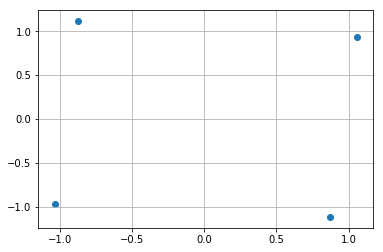

In [42]:
# ploting constellation diagram
import matplotlib.pyplot as plt

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    print("i = " + str(i) + " : " + str(temp))
    expand_dims_ = np.expand_dims(temp,axis=0)
    prediction = encoder.predict(expand_dims_)
    print(prediction)
    scatter_plot.append(prediction)
    print('power:', np.linalg.norm(prediction)/np.sqrt(n_channel))
    print("========================")
scatter_plot = np.array(scatter_plot)

scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

## BER vs. SNR

In [45]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
N = 50000
test_data = generate_random_data(N)
EbNodB_range = list(frange(0,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    measure_overhead_start_time = perf_counter()
    measure_overhead_end_time = perf_counter()
    measure_overhead_total_time = measure_overhead_end_time - measure_overhead_start_time
    print('Measure overhead total time = ' + str((measure_overhead_total_time)*1000000) + "us")
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    noise = noise_std * np.random.randn(N,n_channel)
    tx_start_time = perf_counter()
    encoded_signal = encoder.predict(test_data)
    tx_end_time = perf_counter()
    print('TX total time = ' + str((tx_end_time - tx_start_time - measure_overhead_total_time)*1000) + "ms")
    final_signal = encoded_signal + noise
    rx_start_time = perf_counter()
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    rx_end_time = perf_counter()
    print('RX total time = ' + str((rx_end_time - rx_start_time - measure_overhead_total_time)*1000) + "ms")
    print('R         :', R)
    print('Eb/No     :', EbNo)
    print('Eb/No[db] :', EbNodB_range[n])
    print('noise_std :', noise_std)
    print('dist      :', np.linalg.norm(encoded_signal[0] - final_signal[0]))
    print('TX[0] val :', test_label[0])
    print('TX[0] i,q :', encoded_signal[0])
    print('RX[0]     :', pred_output[0])
    print('RX[0] i,q :', final_signal[0])
    print("")
    print('dist      :', np.linalg.norm(encoded_signal[1] - final_signal[1]))
    print('TX[1] val :', test_label[1])
    print('TX[1] i,q :', encoded_signal[1])
    print('RX[1]     :', pred_output[1])
    print('RX[1] i,q :', final_signal[1])
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / N 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])
    print('=================================================')
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')

Measure overhead total time = 1.0269941412843764us
TX total time = 1013.6519650041009ms
RX total time = 1031.8775970008573ms
R         : 1.0
Eb/No     : 1.0
Eb/No[db] : 0
noise_std : 0.7071067811865476
dist      : 1.0415544671094703
TX[0] val : 3
TX[0] i,q : [1.0567629  0.93981504]
RX[0]     : 1
RX[0] i,q : [ 1.05577461 -0.10173895]

dist      : 0.9734950935610429
TX[1] val : 1
TX[1] i,q : [ 0.87164336 -1.1136597 ]
RX[1]     : 1
RX[1] i,q : [ 1.72607578 -1.58017655]
SNR: 0 BER: 0.15342
Measure overhead total time = 0.7689959602430463us
TX total time = 1015.5670030071633ms
RX total time = 1003.496201003145ms
R         : 1.0
Eb/No     : 1.1220184543019633
Eb/No[db] : 0.5
noise_std : 0.6675518474746908
dist      : 1.0186739909170819
TX[0] val : 3
TX[0] i,q : [1.0567629  0.93981504]
RX[0]     : 3
RX[0] i,q : [0.29289085 1.6137558 ]

dist      : 0.6934302567194355
TX[1] val : 1
TX[1] i,q : [ 0.87164336 -1.1136597 ]
RX[1]     : 1
RX[1] i,q : [ 0.8820965 -1.8070112]
SNR: 0.5 BER: 0.13124
Meas

TX total time = 1167.8530520002823ms
RX total time = 1091.613012002199ms
R         : 1.0
Eb/No     : 5.623413251903491
Eb/No[db] : 7.5
noise_std : 0.2981844571770067
dist      : 0.6881551770373044
TX[0] val : 3
TX[0] i,q : [1.0567629  0.93981504]
RX[0]     : 3
RX[0] i,q : [1.22600842 0.27279667]

dist      : 0.49362884684671
TX[1] val : 1
TX[1] i,q : [ 0.87164336 -1.1136597 ]
RX[1]     : 1
RX[1] i,q : [ 0.98418899 -1.59428737]
SNR: 7.5 BER: 0.00084
Measure overhead total time = 0.6740010576322675us
TX total time = 1010.7702370005427ms
RX total time = 1130.9939139973721ms
R         : 1.0
Eb/No     : 6.309573444801933
Eb/No[db] : 8.0
noise_std : 0.2815042799373673
dist      : 0.23664425735674818
TX[0] val : 3
TX[0] i,q : [1.0567629  0.93981504]
RX[0]     : 3
RX[0] i,q : [0.85099417 0.82294024]

dist      : 0.45387305511149295
TX[1] val : 1
TX[1] i,q : [ 0.87164336 -1.1136597 ]
RX[1]     : 1
RX[1] i,q : [ 0.7146809  -1.53952772]
SNR: 8.0 BER: 0.00046


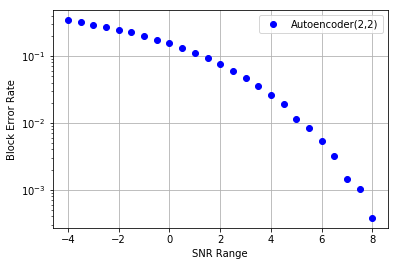

In [23]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder('+str(k)+','+str(n_channel)+')')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid(True)
plt.legend(loc='upper right',ncol = 1)

In [24]:
# Nsymbols = np.floor(np.linspace(10, 1250, 50)).astype(int)
Nsymbols = np.concatenate((np.arange(start=10, stop=200, step=50), 
                           np.arange(start=200, stop=1000, step=100)), axis=0)
print(Nsymbols)
hw_exec_time_vec = np.zeros(len(Nsymbols))
start_time = time.time()
stop_time = time.time()
measure_self_time = stop_time-start_time

for y in range(len(Nsymbols)):
    data_in = generate_random_data(Nsymbols[y])
    in_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
    out_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
    np.copyto(in_buffer,data_in)    
    start_time = time.time()
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    stop_time = time.time()
    hw_exec_time_vec[y] = (stop_time-start_time-measure_self_time)*1000

# Execution time as function of data length
plt.plot(Nsymbols, hw_exec_time_vec)
plt.xlabel('# Symbols (16 Bytes)')
plt.ylabel('Execution time [ms]')
plt.grid(True)
#print(Nsymbols)
#print(hw_exec_time_vec)



In [66]:
Nsymbols = np.concatenate((np.arange(start=10, stop=200, step=50), 
                           np.arange(start=200, stop=10000, step=100)), axis=0)
Ntests = 20

sw_exec_time_vec = np.zeros((Ntests, len(Nsymbols)))
start_time = time.time()
stop_time = time.time()
measure_self_time = stop_time-start_time

for test_id in range(Ntests):
    for y in range(len(Nsymbols)):
        data_in = generate_random_data(Nsymbols[y])

        tx_start_time = time.time()
        encoded_signal = encoder.predict(data_in)
        tx_end_time = time.time()
        tx_time = (tx_end_time - tx_start_time - measure_self_time)*1000
        final_signal = encoded_signal
        rx_start_time = time.time()
        pred_final_signal =  decoder.predict(final_signal)
        pred_output = np.argmax(pred_final_signal,axis=1)
        rx_end_time = time.time()
        rx_time = (rx_end_time - rx_start_time - measure_self_time)*1000
        sw_exec_time_vec[test_id, y] = tx_time + rx_time
    #     print(hw_exec_time_vec[y])
        # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
        #print(ber[n], " ",end='')

In [67]:
mean_sw_exec_time_vec = np.mean(sw_exec_time_vec, axis=0)

In [68]:
mean_sw_exec_time_vec

array([  1.33718252,   2.48003006,   4.728055  ,   5.84330559,
         8.58491659,  12.78574467,  14.53801394,  18.90070438,
        22.55301476,  25.4357934 ,  28.84516716,  32.89698362,
        37.28247881,  41.18812084,  42.68226624,  46.46191597,
        49.51156378,  52.9309392 ,  58.74325037,  61.30627394,
        66.55865908,  68.87162924,  71.54535055,  77.36371756,
        82.05834627,  82.76798725,  85.5718255 ,  88.1354332 ,
        92.7267909 ,  99.04347658, 103.23832035, 105.39360046,
       107.30762482, 110.28927565, 114.98961449, 118.9084053 ,
       122.89119959, 124.81124401, 128.98906469, 132.92633295,
       134.45657492, 140.55957794, 143.01980734, 148.7409234 ,
       150.6405592 , 157.7855587 , 158.46712589, 159.66328382,
       166.34050608, 171.93937302, 177.63944864, 174.51050282,
       179.4383049 , 186.94297075, 191.83291197, 194.44311857,
       203.51091623, 198.85662794, 201.02648735, 205.26673794,
       209.74487066, 214.92580175, 216.94688797, 222.54